<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [88]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Install PySR and PyTorch-Lightning:

In [89]:
%pip install -Uq pysr pytorch_lightning --quiet

In [90]:
%pip install julia

In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

In [3]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [6]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [33]:
df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']

girderName = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'girderName'].values
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values * np.pi / 180
O = (w_oh * 10).astype(int)
tss = (ts * 10).astype(int)
models = girderName + '-L_' + L.astype(str) + '-Nb_' + Nb.astype(str) + '-S_' + (S*10).astype(str) + '-O_' + O.astype(str) + '-ts_' + tss.astype(str)
print(models)
# n_r1_sk0 = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'n_r1'].values
# n_r1_sk30 = df.loc[(df['skew'] == 30), 'n_r1'].values
# n_r1_sk45 = df.loc[(df['skew'] == 45), 'n_r1'].values
# n_r1_sk60 = df.loc[(df['skew'] == 60), 'n_r1'].values

# x_trial = df.loc[(df['skew'] != 0), 'x_trial'].values
# x_trial30 = df.loc[(df['skew'] == 30), 'x_trial'].values
# x_trial45 = df.loc[(df['skew'] == 45), 'x_trial'].values
# x_trial60 = df.loc[(df['skew'] == 60), 'x_trial'].values

# n_r1_skew = df.loc[(df['skew'] != 0), 'n_r1'].values
# sk30_r1_correction = n_r1_sk30 / n_r1_sk0
# sk45_r1_correction = n_r1_sk45 / n_r1_sk0
# sk60_r1_correction = n_r1_sk60 / n_r1_sk0
# # sk_r1_correction = n_r1_skew / n_r1_sk0

skews = [30, 45]
sk_bm1_correction = []
sk_bm2_correction = []
sk_r1_correction = []
sk_r2_correction = []
x_L, x_S, x_D, x_Nb, x_skew, x_w_oh, x_trial, x_tan_skew, x_AR = [], [], [], [], [], [], [], [], []

for skew in skews:
  for model in models:
    skew_model = model + '-sk_' + str(skew)
    normal_model = model
    n_bm1_skewed = df.loc[(df['model'] == skew_model) , 'n_bm1'].values
    n_bm1_normal = df.loc[(df['model'] == normal_model) , 'n_bm1'].values
    n_bm2_skewed = df.loc[(df['model'] == skew_model) , 'n_bm2'].values
    n_bm2_normal = df.loc[(df['model'] == normal_model) , 'n_bm2'].values
    n_r1_skewed = df.loc[(df['model'] == skew_model) , 'n_r1'].values
    n_r1_normal = df.loc[(df['model'] == normal_model) , 'n_r1'].values
    n_r2_skewed = df.loc[(df['model'] == skew_model) , 'n_r2'].values
    n_r2_normal = df.loc[(df['model'] == normal_model) , 'n_r2'].values
    sk_bm1_correction.extend(n_bm1_skewed / n_bm1_normal)
    sk_bm2_correction.extend(n_bm2_skewed / n_bm2_normal)
    sk_r1_correction.extend(n_r1_skewed / n_r1_normal)
    sk_r2_correction.extend(n_r2_skewed / n_r2_normal)
    x_L.extend(df.loc[(df['model'] == skew_model) , 'L'].values)
    x_S.extend(df.loc[(df['model'] == skew_model) , 'S'].values)
    x_D.extend(df.loc[(df['model'] == skew_model) , 'D'].values)
    x_Nb.extend(df.loc[(df['model'] == skew_model) , 'Nb'].values)
    x_skew.extend(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180)
    # x_tan_skew.extend(np.tan(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180))
    x_w_oh.extend(df.loc[(df['model'] == skew_model) , 'w_oh'].values)
    x_trial.extend(df.loc[(df['model'] == skew_model) , 'x_trial'].values)


['Tx28-L_42-Nb_4-S_60-O_15-ts_85' 'Tx28-L_42-Nb_4-S_60-O_20-ts_85'
 'Tx28-L_42-Nb_4-S_60-O_25-ts_85' ... 'Tx84-L_210-Nb_7-S_120-O_36-ts_85'
 'Tx84-L_210-Nb_7-S_120-O_48-ts_85' 'Tx84-L_210-Nb_7-S_120-O_60-ts_85']


In [34]:
x_tan_skew = np.tan(x_skew)
x_cos_skew = np.cos(x_skew)
x_sin_skew = np.sin(x_skew)
print(sk_r1_correction[2304:])
print(x_skew)
print(x_tan_skew)

[]
[0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.52359877559829

In [68]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_r1_correction
print(X.shape)
# print(y.shape)
print(X)

(2304, 4)
[[ 42.           6.           1.5          0.57735027]
 [ 42.           6.           2.           0.57735027]
 [ 42.           6.           2.5          0.57735027]
 ...
 [210.          12.           3.61111111   1.        ]
 [210.          12.           4.80555556   1.        ]
 [210.          12.           6.           1.        ]]


In [69]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/'],
    unary_operators=["square", "sqrt"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-4,4),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.080e+03
Head worker occupation: 66.1%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 15 / 5000 total iterations (0.300%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.031e-02  7.971e+00  y = sqrt(1.2456)
5           1.028e-02  9.907e-04  y = sqrt(sqrt(x₃ + 0.72867))
6           9.850e-03  4.275e-02  y = sqrt(sqrt(0.71543 + sqrt(x₃)))
7           8.539e-03  1.428e-01  y = 1.1418 + ((x₂ / x₀) / -0.8959)
9           8.512e-03  1.538e-03  y = 1.1418 + (((x₂ * 1.3359) / x₀) / -0.8959)
10          6.878e-03  2.132e-01  y = sqrt(sqrt(sqrt(1.0235) / (0.062806 * (x₁ + x₃))))
11          6.562e-03  4.699e-02  y = sqrt(sqrt(sqrt(1.0274) / (0.062806 * (sqrt(x₃) + x₁))))
12          6.416e-03  2.255e-02  y = sqrt(sqrt(square(sqrt(sqrt(1.0235))) / ((x₁ + 0.8

In [70]:
n = 14
model.sympy(n)


(x0/(x1 + x2/x3 - x3/(x2 - 0.38983855))**2 + 0.80890876)**(1/4)

In [71]:
y_pred = model.predict(X,n)
print("Default selection MSE:", np.power(y_pred - y, 2).mean())
r2 = r2_score(y_pred, y)
print(f"R²: {r2:.4f}")

Default selection MSE: 0.0019775633815521635
R²: 0.7787


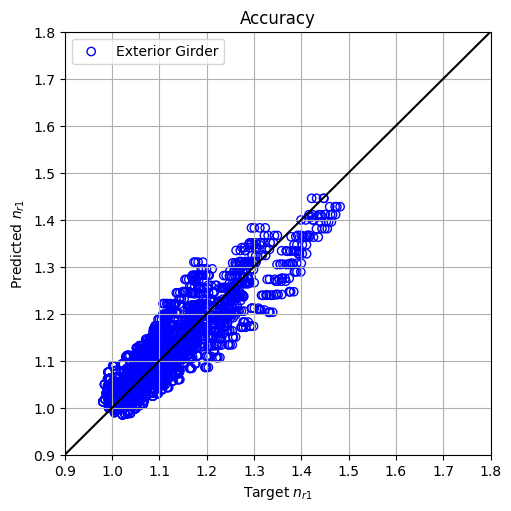

In [72]:
x_line = [0.9, 1.8]
y_line = [0.9, 1.8]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.8))
plt.ylim((0.9,1.8))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

1.38665450000000
Default selection MSE: 0.08155055165872557
R²: -1654041692146027222924481527808.0000
1.11972018826134
Default selection MSE: 0.010296893279430794
R²: 0.0000
0.88521606 + 1.9481922/x1
Default selection MSE: 0.005741357654457682
R²: -0.2603
0.9996979 + 7.6499743/(x1**2)
Default selection MSE: 0.00573666497176761
R²: -0.2579
sqrt(x0)/x1**2 + 0.9625164
Default selection MSE: 0.004206284704166551
R²: 0.5405
0.18931991*sqrt(x0)/x1 + 0.89138347
Default selection MSE: 0.0036706436193371522
R²: 0.4460
0.98141456 + sqrt(x0*x3)/x1**2
Default selection MSE: 0.0032232903858414766
R²: 0.5745
(x0/(x1**2*x2) + 0.966723)**(1/4)
Default selection MSE: 0.0028699650882165135
R²: 0.6321
1.0289657 + (-x2 + sqrt(x0*x3))/x1**2
Default selection MSE: 0.0027015955697763977
R²: 0.4837
(x0/(x1 + x2/x3)**2 + 0.85704124)**(1/4)
Default selection MSE: 0.0021149398658159967
R²: 0.6976
(x0/(x1 + x2/x3)**2 + 0.85661393)**(1/4)
Default selection MSE: 0.0021149332399404337
R²: 0.6977
(x0/(-x1 + (x1 + x2/

IndexError: single positional indexer is out-of-bounds

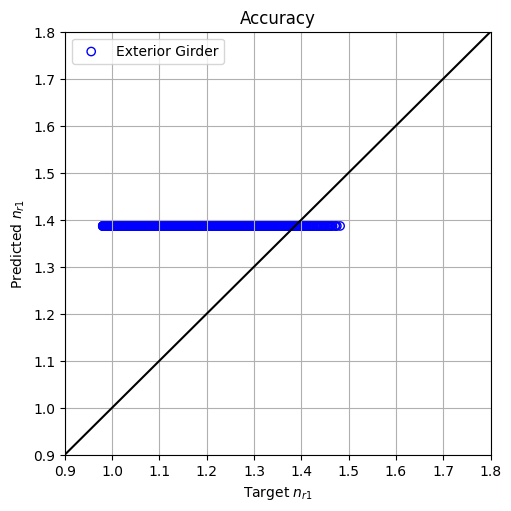

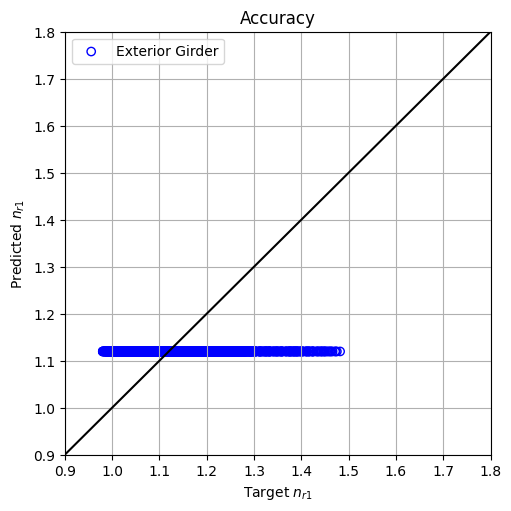

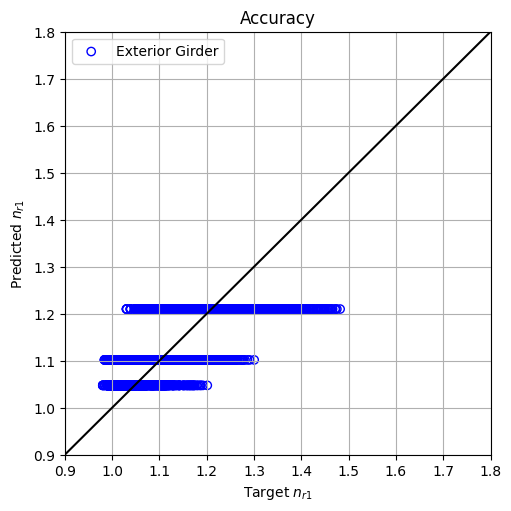

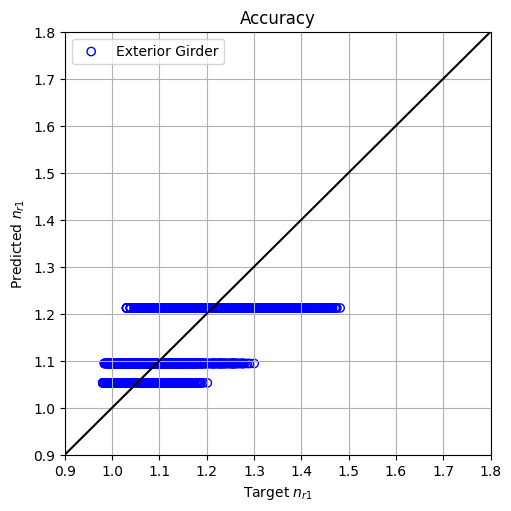

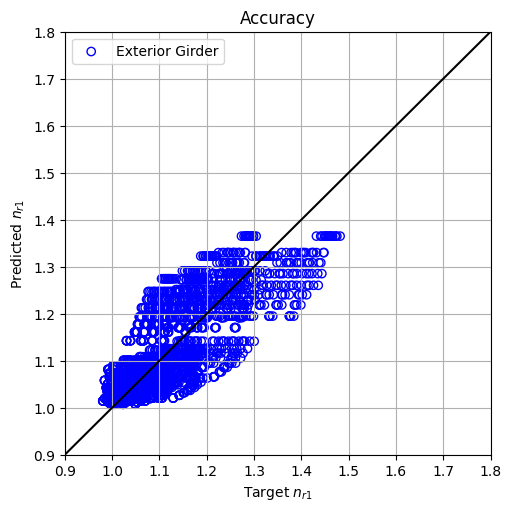

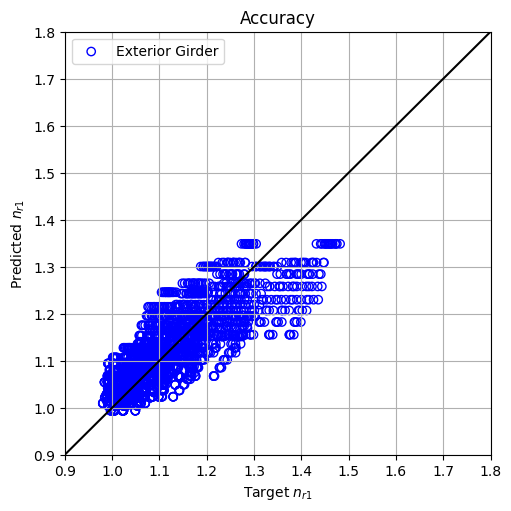

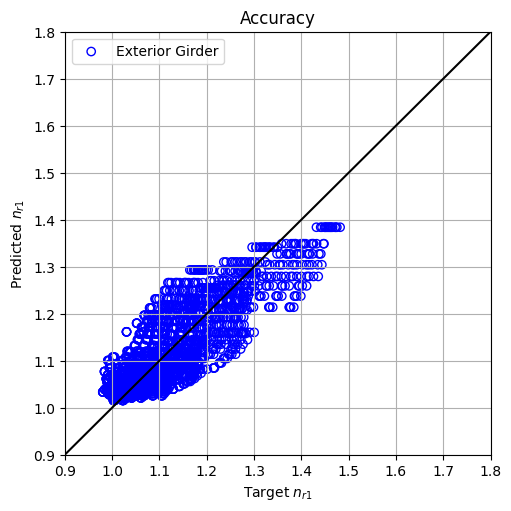

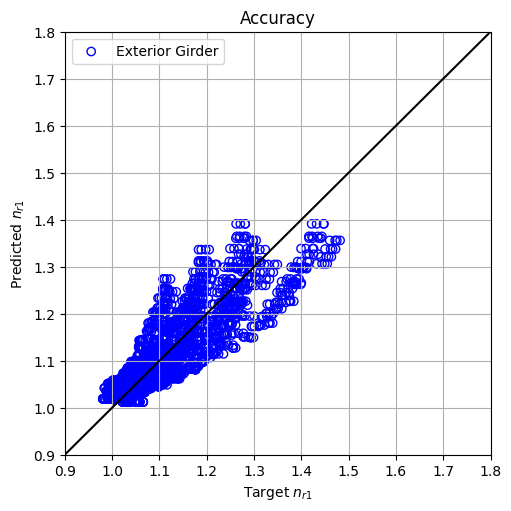

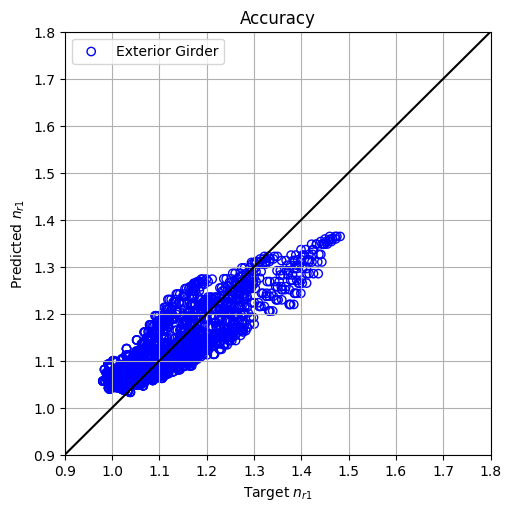

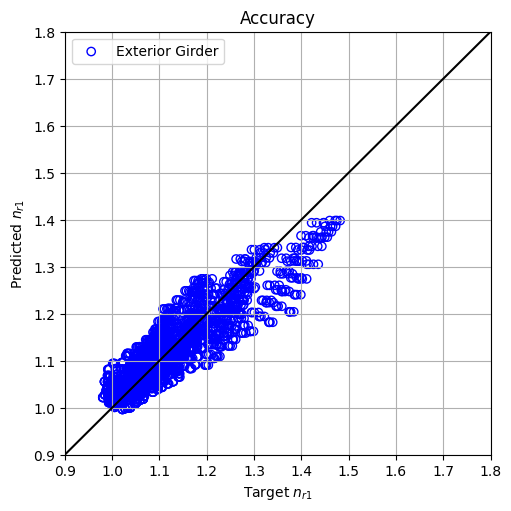

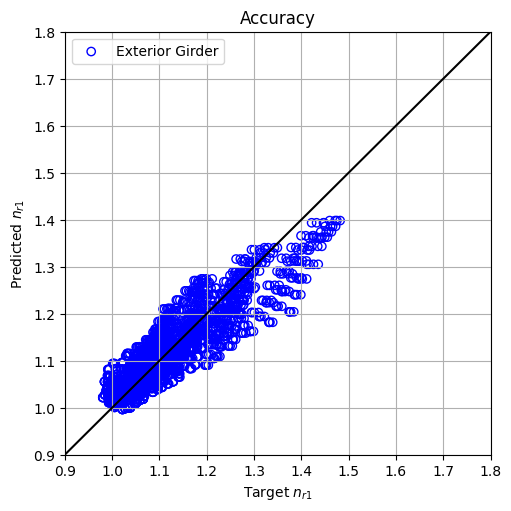

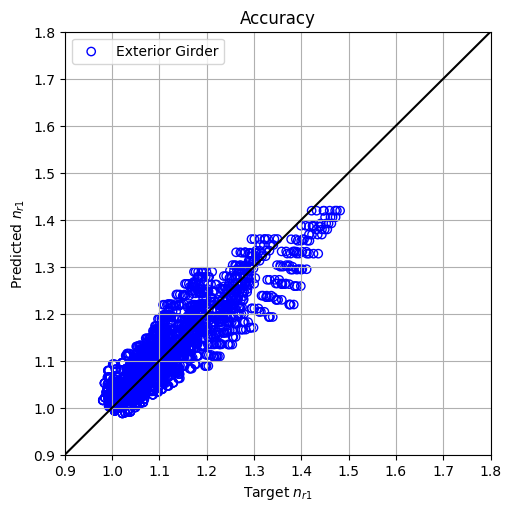

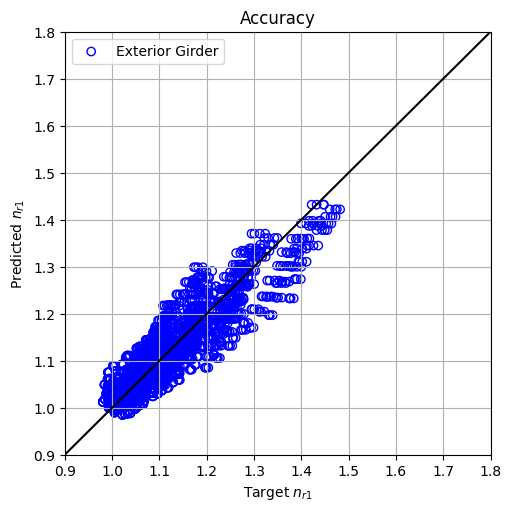

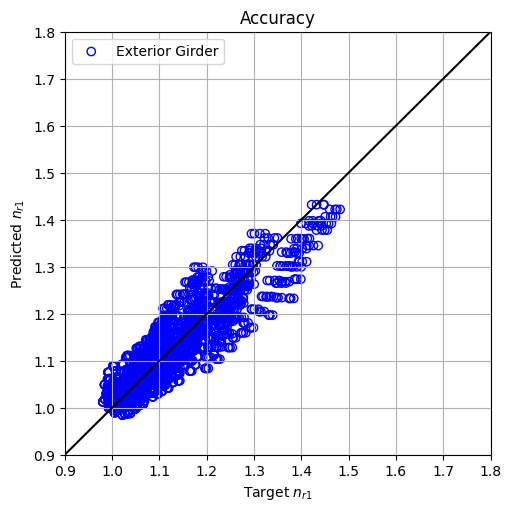

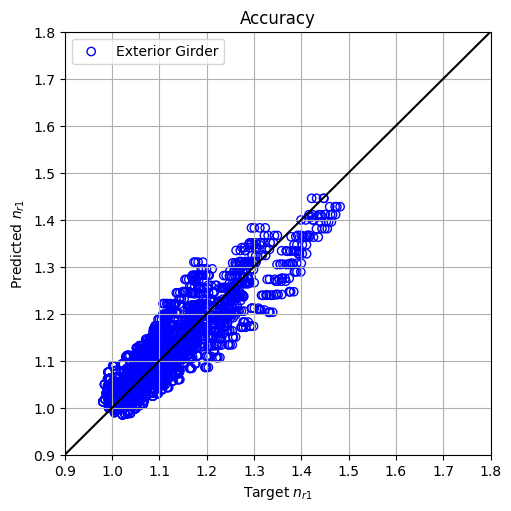

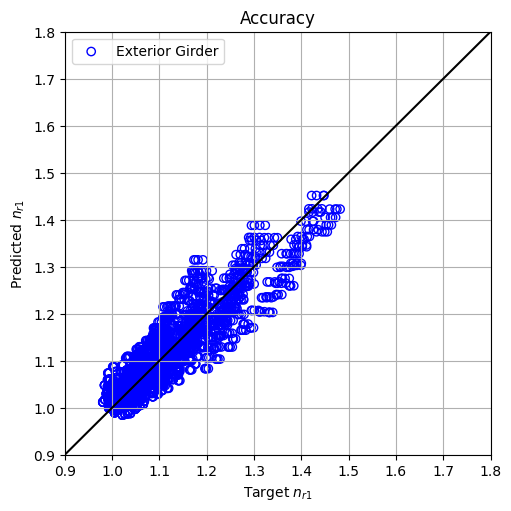

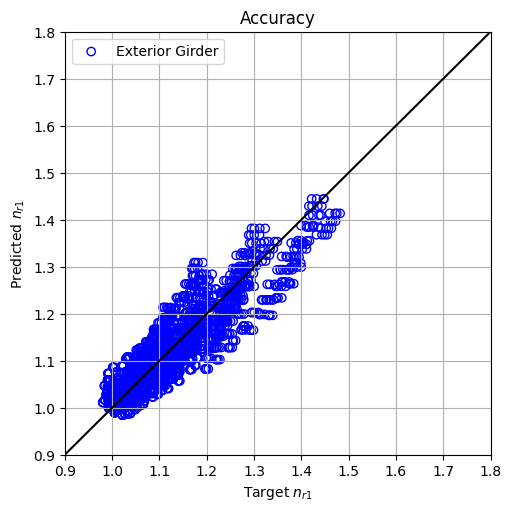

In [73]:
for i in range(20):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  r2 = r2_score(y_pred, y)
  print(f"R²: {r2:.4f}")
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [ ]:
model.latex()

'0.000762 x_{4} + 0.843 + \\frac{0.0247}{x_{5}}'

$0.000762 D_{4} + 0.843 + \frac{0.0247 L}{(S+w_{oh})tan(skew)(D/28)}$